In [6]:
import sys
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.distributions.categorical import Categorical
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
"""
在pytorch中实现字符级语言建模
"""

#准备数据
with open('1268-0.txt', 'r', encoding="utf8") as fp:
    text=fp.read()
    
start_indx = text.find('THE MYSTERIOUS ISLAND')
end_indx = text.find('End of the Project Gutenberg')

text = text[start_indx:end_indx]
char_set = set(text)
print('Total Length:', len(text))
print('Unique Characters:', len(char_set))

Total Length: 1112350
Unique Characters: 80


In [4]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)}   #创建char2int将每个字符映射为一个整数
char_array = np.array(chars_sorted)#使用NumPy库，将排序后的字符列表chars_sorted转换成一个NumPy数组char_array，用于反向映射

text_encoded = np.array(
    [char2int[ch] for ch in text],
    dtype=np.int32)
"""
遍历原始文本字符串text中的每个字符，使用char2int字典将每个字符转换为相应的整数编码，然后将这些整数编码存储在一个NumPy数组text_encoded中，指定数据类型为np.int32。
"""
print('Text encoded shape: ', text_encoded.shape)

print(text[:15], '     == Encoding ==> ', text_encoded[:15])
print(text_encoded[15:21], ' == Reverse  ==> ', ''.join(char_array[text_encoded[15:21]]))

Text encoded shape:  (1112350,)
THE MYSTERIOUS       == Encoding ==>  [44 32 29  1 37 48 43 44 29 42 33 39 45 43  1]
[33 43 36 25 38 28]  == Reverse  ==>  ISLAND


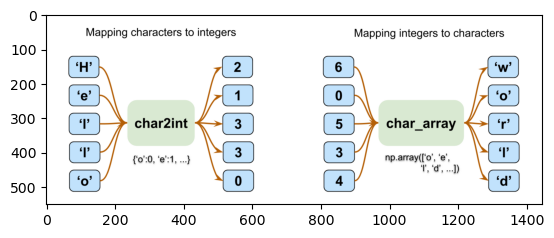

In [7]:
img = Image.open('15_12.png')
plt.imshow(img)

In [8]:
for ex in text_encoded[:5]:
    print('{} -> {}'.format(ex, char_array[ex]))

44 -> T
32 -> H
29 -> E
1 ->  
37 -> M


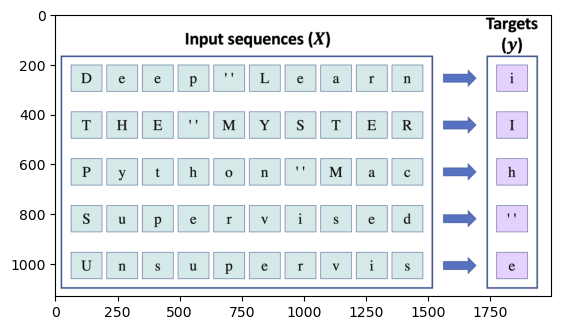

In [9]:
img = Image.open('15_13.png')
plt.imshow(img)
#从宏观角度来讲，可以把文本生成任务看作分类任务

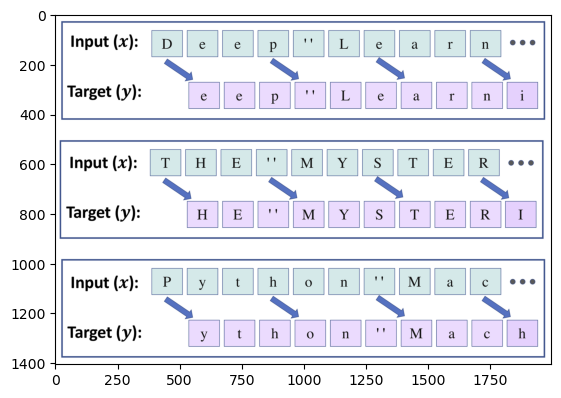

In [11]:
img = Image.open('15_14.png')
plt.imshow(img)
#从长度为1的序列（即单个字母）开始，使用多分类方法迭代生成文本

In [12]:
class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)
    
    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long()

In [16]:
seq_length = 40 #设置输入张量长度40
chunk_size = seq_length + 1

#将原始顺序存储在text_encoded中的编码文本块分割长度为41的文本块，前40个字符为输入序列x，后40个字符为目标序列y
text_chunks = [text_encoded[i:i+chunk_size] 
               for i in range(len(text_encoded)-chunk_size+1)] 
seq_dataset = TextDataset(torch.tensor(text_chunks))

In [17]:
## inspection:
for seq in text_chunks[:1]:
    input_seq = seq[:seq_length]
    target = seq[seq_length] 
    print(input_seq, ' -> ', target)
    print(repr(''.join(char_array[input_seq])), 
          ' -> ', repr(''.join(char_array[target])))

[44 32 29  1 37 48 43 44 29 42 33 39 45 43  1 33 43 36 25 38 28  1  6  6
  6  0  0  0  0  0 40 67 64 53 70 52 54 53  1 51]  ->  74
'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'  ->  'y'


In [18]:
for i, (seq, target) in enumerate(seq_dataset):
    print(' Input (x):', repr(''.join(char_array[seq])))
    print('Target (y):', repr(''.join(char_array[target])))
    print()
    if i == 1:
        break

 Input (x): 'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'
Target (y): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'

 Input (x): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'
Target (y): 'E MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by '



In [19]:
device = torch.device("cuda:0")
# device = 'cpu'

batch_size = 64

torch.manual_seed(1)
seq_dl = DataLoader(seq_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [20]:
#####构建循环神经网络模型
class RNN(nn.Module):
    """
    __init__(self, vocab_size, embed_dim, rnn_hidden_size): 这是类的构造函数，用于初始化网络结构。
        vocab_size: 词汇表的大小，即输入序列中可能的单词或符号的数量。
        embed_dim: 嵌入层的维度，即每个单词或符号被嵌入成多少维的向量。
        rnn_hidden_size: RNN隐藏层的维度。
    """
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim) #定义了一个嵌入层，用于将输入的单词索引（整数）转换为对应的嵌入向量。
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, #定义了一个LSTM层，其输入维度为embed_dim，输出（隐藏状态）维度为rnn_hidden_size。batch_first=True表示输入张量的第一个维度是批次大小。
                           batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)# 定义了一个全连接层，用于将LSTM的输出转换为最终的输出，其输出维度为vocab_size，与词汇表大小相同，通常用于生成预测序列。

    def forward(self, x, hidden, cell): #hidden, cell:LSTM层的初始隐藏状态和细胞状态，形状均为(num_layers, batch_size, rnn_hidden_size)。由于这里只使用了一层LSTM，所以num_layers为1。
                                        # x:输入的序列，形状为(batch_size, seq_len)。
        out = self.embedding(x).unsqueeze(1)#首先将输入x通过嵌入层，然后增加一个维度以匹配LSTM层的输入要求（LSTM期望输入形状为(batch_size, seq_len, embed_dim)）。
                                        #代码中unsqueeze(1)的使用是为了匹配LSTM层期望的输入形状。
        out, (hidden, cell) = self.rnn(out, (hidden, cell))#将嵌入后的输入传递给LSTM层，得到输出和更新后的隐藏状态、细胞状态。
        out = self.fc(out).reshape(out.size(0), -1)#将LSTM的输出通过全连接层，然后重新整形，以便每个时间步的输出都被平铺成一个向量。
        return out, hidden, cell    #返回LSTM整形后的向量、隐藏状态、细胞状态

    def init_hidden(self, batch_size):  #初始化LSTM层的隐藏状态和细胞状态
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)#hidden和cell均初始化为形状为(1, batch_size, rnn_hidden_size)的全零张量。
        return hidden.to(device), cell.to(device)#.to(device): 将张量移动到指定的设备上（如CPU或GPU）

In [21]:
vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size) 
model = model.to(device)
model

RNN(
  (embedding): Embedding(80, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=80, bias=True)
)

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [23]:
num_epochs = 10000 

torch.manual_seed(1)

for epoch in range(num_epochs):
    hidden, cell = model.init_hidden(batch_size)
    seq_batch, target_batch = next(iter(seq_dl))
    seq_batch = seq_batch.to(device)
    target_batch = target_batch.to(device)
    optimizer.zero_grad()
    loss = 0
    for c in range(seq_length):
        pred, hidden, cell = model(seq_batch[:, c], hidden, cell) #将当前时间步的输入、上一个时间步的隐藏状态和细胞状态传递给模型，得到预测结果和更新后的隐藏状态、细胞状态。
        loss += loss_fn(pred, target_batch[:, c])
    loss.backward()#计算总损失的梯度。
    optimizer.step()#根据计算得到的梯度更新模型的参数。
    loss = loss.item()/seq_length
    if epoch % 500 == 0:
        print(f'Epoch {epoch} loss: {loss:.4f}')

Epoch 0 loss: 4.3722
Epoch 500 loss: 1.3871
Epoch 1000 loss: 1.3605
Epoch 1500 loss: 1.2203
Epoch 2000 loss: 1.2336
Epoch 2500 loss: 1.2102
Epoch 3000 loss: 1.1445
Epoch 3500 loss: 1.1396
Epoch 4000 loss: 1.1980
Epoch 4500 loss: 1.1537
Epoch 5000 loss: 1.0865
Epoch 5500 loss: 1.1293
Epoch 6000 loss: 1.1541
Epoch 6500 loss: 1.1276
Epoch 7000 loss: 1.1134
Epoch 7500 loss: 1.1681
Epoch 8000 loss: 1.1381
Epoch 8500 loss: 1.1622
Epoch 9000 loss: 1.1105
Epoch 9500 loss: 1.1002


In [30]:
#评估文本生成模型
torch.manual_seed(1)
logits = torch.tensor([[1.0, 1.0, 1.0]])
print('Probabilities:', nn.functional.softmax(logits, dim=1).numpy()[0])

m = Categorical(logits=logits)#创建了一个以logits为参数的Categorical分布对象m
samples = m.sample((10,))
print(samples.numpy())

Probabilities: [0.33333334 0.33333334 0.33333334]
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [2]
 [1]
 [1]]


In [26]:
torch.manual_seed(1)
logits = torch.tensor([[1.0, 1.0, 3.0]])
print('Probabilities:', nn.functional.softmax(logits, dim=1).numpy()[0])

m = Categorical(logits=logits)
samples = m.sample((10,))
print(samples.numpy())

Probabilities: [0.10650698 0.10650698 0.78698605]
[[0]
 [2]
 [2]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]]


In [32]:
def sample(model, starting_str, len_generated_text=500, scale_factor=1.0):#给定starting_str生成新字符串generated_str

    encoded_input = torch.tensor([char2int[s] for s in starting_str])   #将起始字符串starting_str中的每个字符通过char2int字典转换为整数索引，并创建一个PyTorch张量
    encoded_input = torch.reshape(encoded_input, (1, -1))               #张量重塑为形状(1, -1)，其中-1表示自动计算该维度的大小，以适应输入数据的长度。这样做是为了符合模型输入的形状要求。

    generated_str = starting_str            #初始化生成的字符串为起始字符串。

    model.eval()
    hidden, cell = model.init_hidden(1)
    hidden = hidden.to('cpu')
    cell = cell.to('cpu')
    #通过一个循环，使用起始字符串中的每个字符（除了最后一个）来更新模型的隐藏状态和细胞状态。
    #注意，这里对encoded_input[:, c].view(1)进行了处理，以确保输入形状与模型期望的输入形状相匹配。
    #然而，这个循环实际上可能是多余的，因为后续代码会重新用最后一个字符更新状态，并且对于生成任务来说，通常不需要先处理整个起始字符串。
    for c in range(len(starting_str)-1):
        _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell) #每次提供给模型一个字符用于更新网络的隐藏状态
    
    last_char = encoded_input[:, -1]
    for i in range(len_generated_text):#生成文本
        logits, hidden, cell = model(last_char.view(1), hidden, cell) 
        logits = torch.squeeze(logits, 0)
        scaled_logits = logits * scale_factor
        m = Categorical(logits=scaled_logits)
        last_char = m.sample()
        generated_str += str(char_array[last_char])
        
    return generated_str

In [35]:
#使用生成的序列作为模型的输入来产生新元素的过程被称为自回归
torch.manual_seed(1)
model.to('cpu')
print(sample(model, starting_str='The island'))

The island was be
bubble, and even an isolating water, which look of anihouse, and stoppering in never about at its
easily proceeded. The species have occurred between the exploration which boy, this evening of existence,
and which was deep in hiurification to right foreover to take, and that they how has some again, found in all reporter, “I
will take feet certainly weighty soon as this private him!” repeated the engineer observed, the two
marvelers laswed in this effer and fastened to the timbers moded 


In [36]:
# * **Predictability vs. randomness**
logits = torch.tensor([[1.0, 1.0, 3.0]])
print('Probabilities before scaling:        ', nn.functional.softmax(logits, dim=1).numpy()[0])
print('Probabilities after scaling with 0.5:', nn.functional.softmax(0.5*logits, dim=1).numpy()[0])
print('Probabilities after scaling with 0.1:', nn.functional.softmax(0.1*logits, dim=1).numpy()[0])

Probabilities before scaling:         [0.10650698 0.10650698 0.78698605]
Probabilities after scaling with 0.5: [0.21194156 0.21194156 0.57611686]
Probabilities after scaling with 0.1: [0.3104238  0.3104238  0.37915248]


In [37]:
torch.manual_seed(1)
print(sample(model, starting_str='The island', 
             scale_factor=2.0))

The island was to
be difficult to us a singulate and the corral. But the sailor and his companions lay an instant had been parts, and the sailor and his companions had been seen to separate in the islet.

“I will think on the 21st of October, the captain?”

“Then a specimens of the corral, and the colonists, who was the colonists, several times for the peccary special size, and the other privation was deceived with extremity of the lower difficulty on the eastern coast.

The engineer then showed themselve


In [38]:
torch.manual_seed(1)
print(sample(model, starting_str='The island', 
             scale_factor=0.5))

The islandrspot!

Iz’NIt,”--they wutn its builded zortaway
Calson of anihway;, 7741st pigraduallyn; a
syy and to Granite Pencroft has bar, stretched byoun; and--doubtlaky fastated,
smoked
to hyin; it--Speration existingoe
away. He? was deedure heurman; snstauk.-x.. Allino/ts of the This were:” org how has. To ;ad them.
In 5!”

Bgorez of Gery,
since then exide only spiemies. “sLad him bild.”

Sawbk, we have recemente,
tried of almig’hod!” what, as coffla,” erilled.

After any fahlemanacy from it. Yet.” he 
